# IMDB
我们要解决的问题是识别一段电影的评论是正面的还是负面的，这是一个二分类问题。我们使用到的数据是 5W 条严重两极分化的电影评论。我们将使用 2.5W 条数据用于训练，2.5W条数据用于测试。


# 1、数据集
首先需要加载数据集

In [1]:
from keras.datasets import imdb

(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=10000)


2023-05-30 23:32:06.815199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


参数 num_words=10000 的意思是仅保留训练数据中前10000个最常出现的单词。低频单词将被舍弃。下面我们看一下数据的内容。

In [2]:
print(train_data.shape)
print(len(train_data[3]))

print(train_data[3])

(25000,)
550
[1, 4, 2, 2, 33, 2804, 4, 2040, 432, 111, 153, 103, 4, 1494, 13, 70, 131, 67, 11, 61, 2, 744, 35, 3715, 761, 61, 5766, 452, 9214, 4, 985, 7, 2, 59, 166, 4, 105, 216, 1239, 41, 1797, 9, 15, 7, 35, 744, 2413, 31, 8, 4, 687, 23, 4, 2, 7339, 6, 3693, 42, 38, 39, 121, 59, 456, 10, 10, 7, 265, 12, 575, 111, 153, 159, 59, 16, 1447, 21, 25, 586, 482, 39, 4, 96, 59, 716, 12, 4, 172, 65, 9, 579, 11, 6004, 4, 1615, 5, 2, 7, 5168, 17, 13, 7064, 12, 19, 6, 464, 31, 314, 11, 2, 6, 719, 605, 11, 8, 202, 27, 310, 4, 3772, 3501, 8, 2722, 58, 10, 10, 537, 2116, 180, 40, 14, 413, 173, 7, 263, 112, 37, 152, 377, 4, 537, 263, 846, 579, 178, 54, 75, 71, 476, 36, 413, 263, 2504, 182, 5, 17, 75, 2306, 922, 36, 279, 131, 2895, 17, 2867, 42, 17, 35, 921, 2, 192, 5, 1219, 3890, 19, 2, 217, 4122, 1710, 537, 2, 1236, 5, 736, 10, 10, 61, 403, 9, 2, 40, 61, 4494, 5, 27, 4494, 159, 90, 263, 2311, 4319, 309, 8, 178, 5, 82, 4319, 4, 65, 15, 9225, 145, 143, 5122, 12, 7039, 537, 746, 537, 537, 15, 7979, 4, 2

train_data 是一个一共包含 25000 元素，每一个元素都是一个 list，list 的元素是一堆正整数，如果你多打印几个，就会发现，正整数的取值是 [1,9999]。因为我们 num_words 参数等于 10000。所以这里的每一个数字都对应了一个英文单词。已 train_data[3] 为例，下面的代码可以回显评论的原文。

In [3]:
word_index = imdb.get_word_index()
# 反转索引，work_index 的 key 是单词，value 是索引，反转后，key 是索引，value 是单词
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
decodede_review = ' '.join(reverse_word_index.get(i-3,'?') for i in train_data[3])
print(decodede_review)


? the ? ? at storytelling the traditional sort many years after the event i can still see in my ? eye an elderly lady my friend's mother retelling the battle of ? she makes the characters come alive her passion is that of an eye witness one to the events on the ? heath a mile or so from where she lives br br of course it happened many years before she was born but you wouldn't guess from the way she tells it the same story is told in bars the length and ? of scotland as i discussed it with a friend one night in ? a local cut in to give his version the discussion continued to closing time br br stories passed down like this become part of our being who doesn't remember the stories our parents told us when we were children they become our invisible world and as we grow older they maybe still serve as inspiration or as an emotional ? fact and fiction blend with ? role models warning stories ? magic and mystery br br my name is ? like my grandfather and his grandfather before him our prota

索引减去了 3 (reverse_word_index.get(i-3,'?')) 是因为 0、1、2 是为 padding（填充）、start of sequence（序列开始）、unknown(未知词)保留的索引，这些索引在评论原文里会用 ? 被代替。所以你会看到，每个评论的开头，都是以 ? 开始。因为我们只取了前 10000 个常用词，所以如果评论中出现的这 10000 以外的词也会被 ? 代替。

# 2、数据处理

我们不能直接将 train_data 输入到神经网络，因为数据是不整齐的（每条评论的单词数是不确定的）。所以需要对数据进行转换一下。我们将用一个长度为 10000 的数组来表示一条评论，数组的值为 1 则表示评论中出现过该单词，0 则表示没有出现过。

In [4]:
import numpy as np

def vectorize_sequences(sequences,dimension = 10000):
    # 入参是一个元组
    results = np.zeros((len(sequences),dimension))
    for i,sequence in enumerate(sequences):
        results[i,sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')


看一下现在训练数据的格式


In [5]:
print(x_train[3])

[0. 1. 1. ... 0. 0. 0.]


In [6]:
print(y_train)

[1. 0. 0. ... 0. 1. 0.]


最终的效果就是，一条评论使用一个 长度为 10000 的数组来表示，数组中的值是 1 则表示出现过其下标对应的单词。而 lables 则是一个长度为 25000 的数组，1 为正面评论 0 为负面评论。效果图如下：

![](./resource/IMDB_01.png)

# 3、构建神经网络
我们将构建 2 个中间层，每层有 16 个单元，第三层输出一个数值，表示当前评论的情感。中间层使用 relu 激活函数，第三层使用 sigmoid 激活函数

图像入下图：

![](./resource/IMDB_06.png)


In [7]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape = (10000,)))
model.add(layers.Dense(16,activation='relu',input_shape = (16,)))
model.add(layers.Dense(1,activation='sigmoid'))

2023-05-30 23:32:13.508767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 4、编译模型
因为我们面对的是一个二分类问题（神经网络的最后一层是 sigmoid 函数）。那么最好使用binary_crossentropy（二元交叉熵）损失。这并不是唯一可行的选择，比如你还可以使用mean_squared_error（均方误差）。但对于输出概率值的模型，交叉熵（crossentropy）往往是最好的选择。

In [8]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

# 5、验证数据
为了能够在训练过程中监控模型在从未出现的数据上的表现，可以取出一部分数据用来做验证数据。我们取出训练数据的前 10000 条数据作为验证数据

In [9]:
x_verify = x_train[0:10000]
partial_x_train = x_train[10000:]

y_verify = y_train[0:10000]
partial_y_train = y_train[10000:]

# 6、训练网络


In [10]:
#history = model.fit(partial_x_train,partial_y_train,epochs=20,batch_size = 512,validation_data=(x_verify,y_verify))

# 7、可视化展示
由于训练的次数太多，所以我们将训练结果可视化展示一下。


In [11]:
import matplotlib.pyplot as plt

def show_loss(his):
    loss=his.history['loss']
    val_loss=his.history['val_loss']
    epochs=range(1, len(loss)+1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def show_acc(his):
    accuracy=his.history['accuracy']
    val_accuracy=his.history['val_accuracy']
    epochs=range(1, len(accuracy)+1)

    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation val_accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
#show_loss(history)
#show_acc(history)

通过图表可以看出，训练在第7轮出现过拟合，重新修改网络，我们改成训练 7 轮。

Epoch 1/7
30/30 [==============================] - 1s 29ms/step - loss: 0.5399 - accuracy: 0.7656 - val_loss: 0.4163 - val_accuracy: 0.8673
Epoch 2/7
30/30 [==============================] - 0s 16ms/step - loss: 0.3338 - accuracy: 0.8997 - val_loss: 0.3343 - val_accuracy: 0.8735
Epoch 3/7
30/30 [==============================] - 0s 16ms/step - loss: 0.2423 - accuracy: 0.9242 - val_loss: 0.2890 - val_accuracy: 0.8892
Epoch 4/7
30/30 [==============================] - 0s 16ms/step - loss: 0.1907 - accuracy: 0.9409 - val_loss: 0.3049 - val_accuracy: 0.8758
Epoch 5/7
30/30 [==============================] - 0s 16ms/step - loss: 0.1552 - accuracy: 0.9506 - val_loss: 0.2785 - val_accuracy: 0.8893
Epoch 6/7
30/30 [==============================] - 0s 16ms/step - loss: 0.1304 - accuracy: 0.9600 - val_loss: 0.2870 - val_accuracy: 0.8860
Epoch 7/7
782/782 [==============================] - 1s 1ms/step - loss: 0.3279 - accuracy: 0.8749


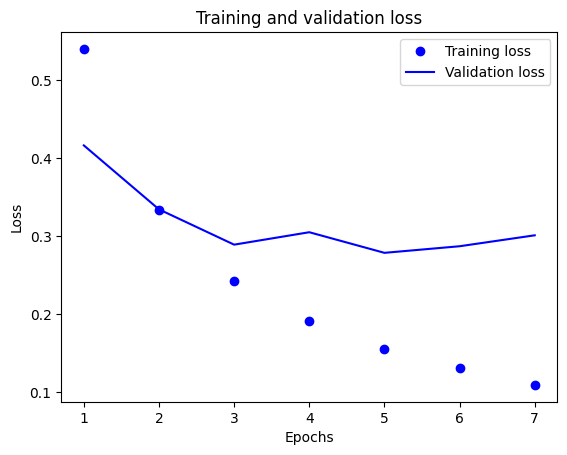

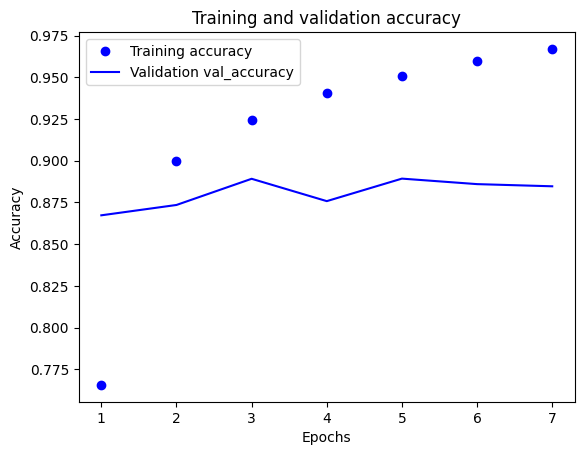

[0.32785096764564514, 0.8748800158500671]


In [12]:
# 注意，这里需要注释掉之前的训练代码。 且需要重启内核
history = model.fit(partial_x_train,partial_y_train,epochs=7,batch_size = 512,validation_data=(x_verify,y_verify))
results = model.evaluate(x_test,y_test)


show_loss(history)
show_acc(history)
print(results)

最终得到了 87% 的准确率。PS：书中是在第 4 轮结束了轮询，达到了 88% 的准确率。

# 8、神经网络内部到底在做什么
下面我们从数据视角看一下神经网络内部在做什么。

# 8.1 输入层
输入层的逻辑很简单，首先通过数据处理后，我们将每一条评论都转换成了一个 长度是 10000 的数组，数组的值是 0 或者 1 ，如果为 1 说明出现对应的单次，为 0 则没有出现。所以输入层包含 10000 个节点，每一个节点的值是 0 或者 1。

# 8.2 隐藏层
隐藏层我们使用的是 Dense 层，全连接层。这一层的每一个节点都接收输入层提供的 10000 个参数，并且内部维护了 每一个参数对应的权重 w，所以每一个节点都维护了 10000 个 w 权重，计算之后 使用 relu 函数计算输出结果。

z[1]<sub>1</sub> = w1 * a[0]<sub>1</sub> + w2 * a[0]<sub>2</sub> + .... + w10000 * a[0]<sub>10000</sub> + b<sub>1</sub>

a[1]<sub>1</sub> = relu( z[1]<sub>1</sub> )

relu函数跟之前介绍的一样，这里不再赘述。

所以这一层的输出共包含 16 个数值，每个节点输出一个数值。a[1]<sub>1</sub> - a[1]<sub>16</sub>

隐藏层的第二层的输入就是这 16 个数值。 第二层的每个节点接收上一层提供的 16 个参数，维护了 16 个 w 的权重。最终也是使用 relu 计算每一个节点的输出。

z[2]<sub>1</sub> = w1 * a[1]<sub>1</sub> + w2 * a[1]<sub>2</sub> + .... + w16 * a[1]<sub>16</sub> + b<sub>1</sub>

a[2]<sub>1</sub> = relu( z[2]<sub>1</sub> )

# 8.3 输出层
输出层只有一个节点，输出的也只有一个数值，取值范围是 (0,1)，表示预测的评论情感。这一层接收的是上一层的输出 a[2]<sub>1</sub> - a[2]<sub>16</sub>。计算方式是使用的 sigmoid 激活函数。

首先这个节点同样维护了 16 个 w ，用于计算 z[3] 然后使用 sigmoid 激活函数计算 a[3] 的值，也就是预测的输出。

z[3]<sub>1</sub> = w1 * a[2]<sub>1</sub> + w2 * a[2]<sub>2</sub> + .... + w16 * a[2]<sub>16</sub> + b<sub>1</sub>

a[3]<sub>1</sub> = sigmoid( z[3]<sub>1</sub> )

sigmoid 激活函数入下图：

![](./resource/IMDB_02.png)

函数图像：

![](./resource/IMDB_03.png)

sigmoid 函数会将一个数值映射到区间（0,1）之间。所以 a[2]<sub>1</sub> 的取值是 （0,1）直接的一个数值。这个数值就是对这条评论的情感预测。

# 8.4 损失函数
这次损失函数我们使用的是 binary_crossentropy 这个损失函数的公式为：

![](./resource/IMDB_04.png)


公式中的 output size 是每个批次的大小。y是实际的标签，y hat 就是我们的预测值 a[3]<sub>1</sub> 。根据公式我们可以推测出，如果 y = 0，那么 

loss = - avg(log（1- a[3])) （注意最前面有个负号）。

没记错的话，log 函数是以 2 为底的，函数的图像如下：

![](./resource/IMDB_05.png)

根据图像可以看出，如果我们期望预测的准确（也就是 a[3] 比较接近 y = 0），就要求 loss 越小，然后根据上一篇文章中提到的 **反向传播** 和**梯度下降** 的方式就可以对神经网络上的参数进行更新。

根据损失函数的公式我们也可以看出，我们不是每计算一条数据后就直接更新神经网络中的参数，而是计算一个批次后，对损失函数求平均值，再进行更新参数的。

# 8、结束

到这里就结束了，IMDB 问题的整体流程就是将评论转换成数值，然后将数值输入到神经网络，通过神经网络来预测最终的情绪。整个过程跟上一篇文章的 MNIST 类似，依然是通过给定的数据来调整优化参数 w ,最终来计算预测值。

# 9、总结

神经网络的层：
+ Dense（密集连接层）：可以用来处数值类的数据

激活函数：
+ relu： 一般配合 Dense 使用
+ softmax：用于处理多分类问题，最终输出每个分类的概率
+ sigmoid：用于处理二分类问题，最终输出 0 到 1 之间的概率值

损失函数：
+ categorical_crossentropy：用于多分类问题
+ binary_crossentropy：用于二分类问题

优化器：
+ rmsprop